# Task in this notebook

**List of tasks**
* EDA (Some EDA)
* Image PreProcessing (like augmentation)
* Divided dataset into
* * Train Dataset
* * Validation Dataset
* Basic Modeling Without Pre-Trained and check Loss curve
* Add pre_trained Model and check loss curve
* Some Tuning (if possible)

# 1. Setting basic configurations

In [1]:
from IPython.display import clear_output
!pip install -qU scikit-learn
!pip install -qU wandb
clear_output()

In [2]:
#Basic python libraries
%config Completer.use_jedi = False
import os, re, math, random, shutil, warnings, gc
import glob
import numpy as np, pandas as pd
from IPython import display as ipd
from tqdm import tqdm

#Classical Ml tools
import sklearn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#OpenCV Library
import cv2

#Plotting tools 
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Tensorflow and keras tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.python.client import device_lib
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

#Logging tools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid too many logging messages
pd.options.mode.chained_assignment = None
tf.get_logger().setLevel('ERROR')
py.init_notebook_mode(connected=True)


In [3]:

import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token.\
    Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token.    Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [4]:
devices = ['TPU', 'GPU']
img_size = [(1024,512), (512,256)]
img_ext = ['png']
#(512,256)

class Config:
    
    def __init__(self):
        self.wandb = True
        self.competition   = 'rsna-bcd' 
        self._wandb_kernel = 'awsaf49'
        self.debug        = False
        self.comment = 'EfficientNetV1B4-1024x512-roi-up=10-lr4-focal-vflip-wb'
        self.exp_name = 'roi-v2-fix' # name of the experiment, folds will be grouped using 'exp_name'
        # use verbose=0 for silent, vebose=1 for interactive,
        self.verbose = 1
        self.display_plot = True
        
        self.model_name = 'EfficientNetV1B4'
        
        # number of folds for data-split
        self.folds = 5
        
       # which folds to train
        self.selected_folds = [0, 1, 2]
        
        
        self.project_name="RSNA_BCD_Modeling"
        self.device=devices[0]
        self.seed=150
        
        self.path='/kaggle/input/rsna-bcs-imagepreprosessing/'
        self.training_imgs= self.path+'train_images'
        
        self.training_images_path='/kaggle/working/Training_Images/'
        self.validations_images_path='/kaggle/working/Validation_Images/'
        self.cancerous='Cancerous/'
        self.non_cancerous='Non_cancerous/'
        self.train_csv=self.path+'TrainDataset.csv'
        self.img_size = img_size[1]
        self.img_ext = img_ext[0]
        self.batch_size = 28
        
        self.epochs = 10
        
        # up sample
        self. upsample = 10
        
        # optimizer
        self.optimizer = 'Adam'
        
        # augmentation
        self.augment   = True
        

config=Config()
        

# 2. Seeding Random Generators for reproducibility

In [5]:
def seeding(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    #os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    print("Seeding done")
    
seeding(config.seed)

Seeding done


# 3.Configur devices
* device="TPU" for remote-tpu , device="GPU" for GPU

In [6]:
if config.device == 'TPU':
    
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        config.device = "GPU"

if config.device == "GPU"  or config.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
        
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        config.device = "CPU"
if config.device == "GPU":
    print("Num GPUs Available: ", ngpu)

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Using multi GPU
Num GPUs Available:  2
REPLICAS: 2


# GCS Path for TPU
* Remote-TPU requires GCS path. Kaggle Provides that for us 

In [7]:
# if config.device=="TPU":
#     from kaggle_datasets import KaggleDatasets
#     GCS_PATH = KaggleDatasets().get_gcs_path(config.path.split('/')[-1])

In [8]:
# # use gcs_path for remote-tpu
# if config.device=="TPU":
#     config.path = GCS_PATH

In [9]:
train_df = pd.read_csv(config.train_csv)
train_df.head(3)

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,input_image_path,output_image_path
0,0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/462822612.png
1,1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1459541791.png
2,2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1864590858.png


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               54706 non-null  int64  
 1   site_id                  54706 non-null  int64  
 2   patient_id               54706 non-null  int64  
 3   image_id                 54706 non-null  int64  
 4   laterality               54706 non-null  object 
 5   view                     54706 non-null  object 
 6   age                      54669 non-null  float64
 7   cancer                   54706 non-null  int64  
 8   biopsy                   54706 non-null  int64  
 9   invasive                 54706 non-null  int64  
 10  BIRADS                   26286 non-null  float64
 11  implant                  54706 non-null  int64  
 12  density                  29470 non-null  object 
 13  machine_id               54706 non-null  int64  
 14  difficult_negative_cas

# 3. Exploratory Data Analysis (EDA)

**Train-Test Ditribution**

In [11]:
print('train_files:',train_df.shape[0])
print('test_files:',train_df.shape[0])

train_files: 54706
test_files: 54706


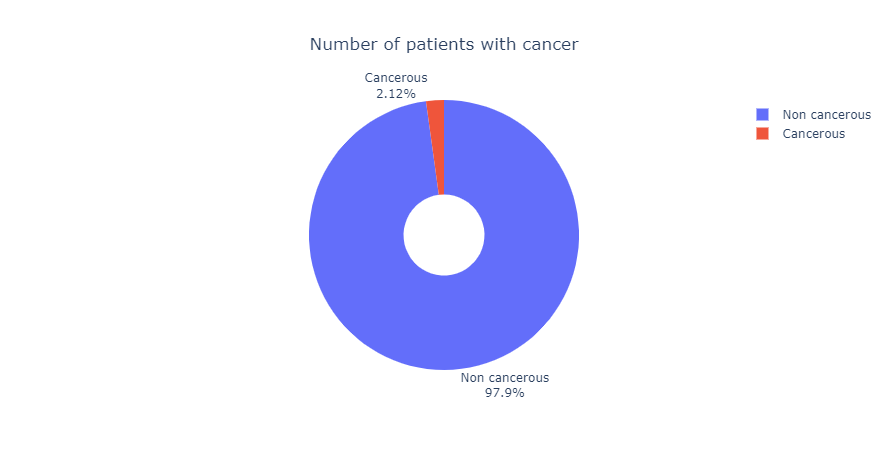

In [12]:
fig = go.Figure(data=[go.Pie(labels=['Non cancerous', 'Cancerous'], values=train_df['cancer'].value_counts(), hole=.3)])
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_text='Number of patients with cancer', title_x=0.5)
fig.show()


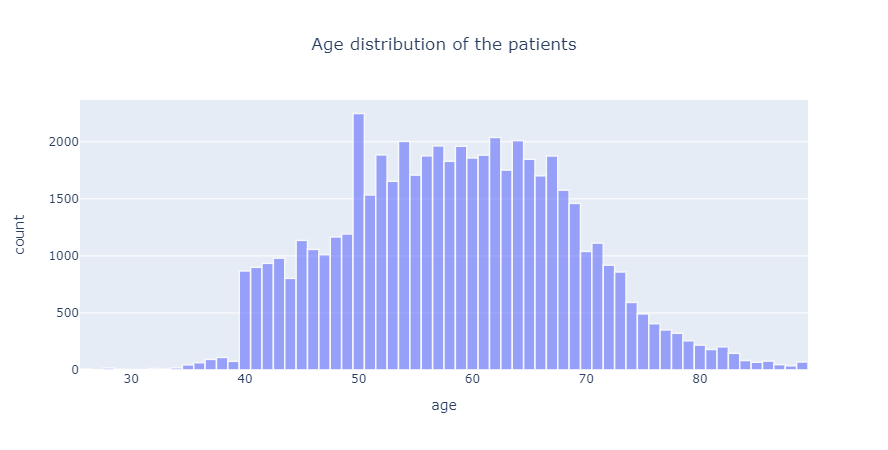

In [13]:
fig = px.histogram(train_df, x="age", title='Age distribution of the patients')
fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_x=0.5)
fig.show()

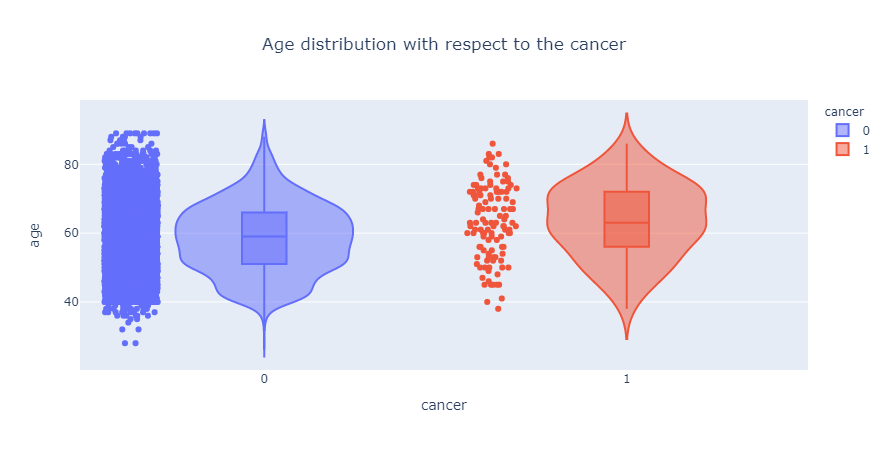

In [14]:

fig = px.violin(train_df.sample(frac=0.1), y="age", x="cancer", color="cancer", box=True, 
                points="all",
                title='Age distribution with respect to the cancer')
fig.update_layout(title_x=0.5)
fig.show()


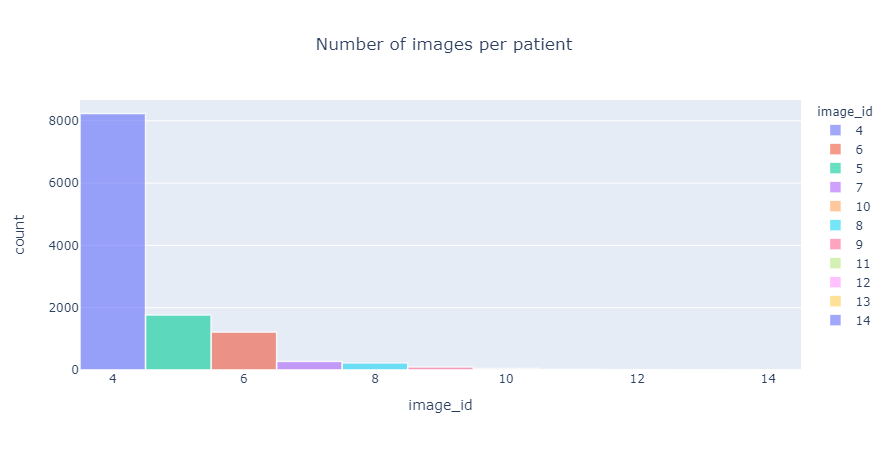

In [15]:
fig = px.histogram(train_df.groupby('patient_id').count().reset_index(), x="image_id", color='image_id',
                   title='Number of images per patient')
fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_x=0.5)
fig.show()

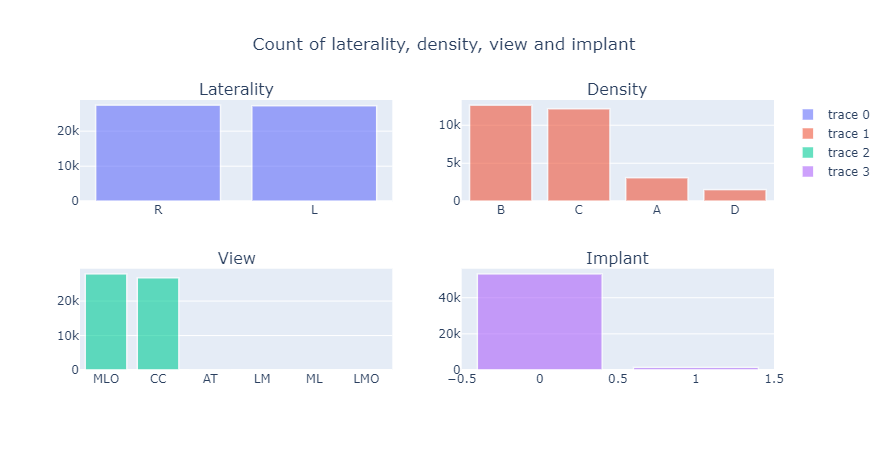

In [16]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Laterality', 'Density', 'View', 'Implant'))

fig.add_trace(go.Bar(x=train_df['laterality'].value_counts().index, y=train_df['laterality'].value_counts().values), row=1, col=1)
fig.add_trace(go.Bar(x=train_df['density'].value_counts().index, y=train_df['density'].value_counts().values), row=1, col=2)
fig.add_trace(go.Bar(x=train_df['view'].value_counts().index, y=train_df['view'].value_counts().values), row=2, col=1)
fig.add_trace(go.Bar(x=train_df['implant'].value_counts().index, y=train_df['implant'].value_counts().values), row=2, col=2)

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Count of laterality, density, view and implant', title_x=0.5)
fig.show()

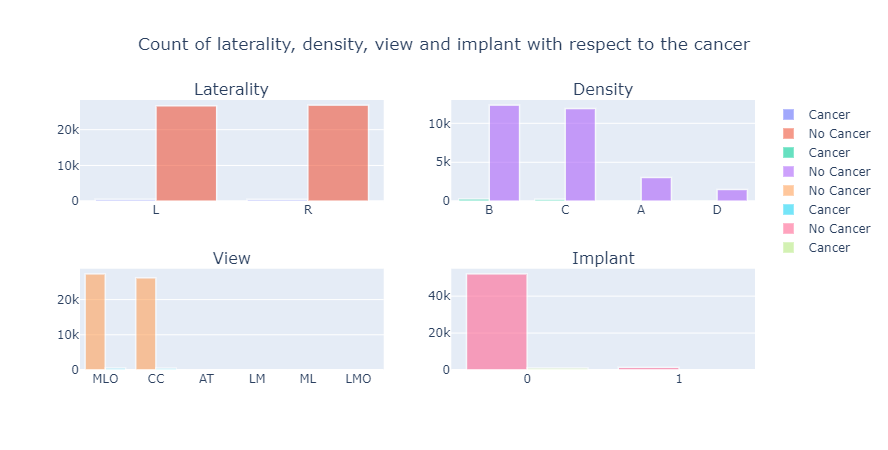

In [17]:
fig = make_subplots(rows=2, cols=2, subplot_titles=('Laterality', 'Density', 'View', 'Implant'))

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['laterality'].value_counts().index, y=train_df[train_df['cancer'] == 1]['laterality'].value_counts().values, name='Cancer'), row=1, col=1)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['laterality'].value_counts().index, y=train_df[train_df['cancer'] == 0]['laterality'].value_counts().values, name='No Cancer'), row=1, col=1)

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['density'].value_counts().index, y=train_df[train_df['cancer'] == 1]['density'].value_counts().values, name='Cancer'), row=1, col=2)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['density'].value_counts().index, y=train_df[train_df['cancer'] == 0]['density'].value_counts().values, name='No Cancer'), row=1, col=2)

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['view'].value_counts().index, y=train_df[train_df['cancer'] == 0]['view'].value_counts().values, name='No Cancer'), row=2, col=1)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['view'].value_counts().index, y=train_df[train_df['cancer'] == 1]['view'].value_counts().values, name='Cancer'), row=2, col=1)

fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 0]['implant'].value_counts().index, y=train_df[train_df['cancer'] == 0]['implant'].value_counts().values, name='No Cancer'), row=2, col=2)
fig.add_trace(go.Bar(x=train_df[train_df['cancer'] == 1]['implant'].value_counts().index, y=train_df[train_df['cancer'] == 1]['implant'].value_counts().values, name='Cancer'), row=2, col=2)

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Count of laterality, density, view and implant with respect to the cancer', title_x=0.5)
fig.show()

# 4. Missing Values 

In [18]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percentage = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
    return pd.concat([total,percentage] , axis = 1 , keys = ['Total' , 'Percent'])

missing_data(train_df)

,Total,Percent
BIRADS,28420,0.519504
density,25236,0.461302
age,37,0.000676
Unnamed: 0,0,0.000000
invasive,0,0.000000
input_image_path,0,0.000000
difficult_negative_case,0,0.000000
machine_id,0,0.000000
implant,0,0.000000
biopsy,0,0.000000


In [19]:
#train_df = train_df.drop(['BIRADS'], axis=1)
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['density'] = train_df['density'].fillna('E')

In [20]:
missing_data(train_df)

,Total,Percent
BIRADS,28420,0.519504
Unnamed: 0,0,0.000000
invasive,0,0.000000
input_image_path,0,0.000000
difficult_negative_case,0,0.000000
machine_id,0,0.000000
density,0,0.000000
implant,0,0.000000
biopsy,0,0.000000
site_id,0,0.000000


In [21]:
train_df['laterality'] = train_df['laterality'].astype('category')
train_df['view'] = train_df['view'].astype('category')
train_df['age'] = train_df['age'].astype('int64')
train_df['output_image_path'] = train_df['output_image_path'].astype('string')

# 5. Fix Data Types

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Unnamed: 0               54706 non-null  int64   
 1   site_id                  54706 non-null  int64   
 2   patient_id               54706 non-null  int64   
 3   image_id                 54706 non-null  int64   
 4   laterality               54706 non-null  category
 5   view                     54706 non-null  category
 6   age                      54706 non-null  int64   
 7   cancer                   54706 non-null  int64   
 8   biopsy                   54706 non-null  int64   
 9   invasive                 54706 non-null  int64   
 10  BIRADS                   26286 non-null  float64 
 11  implant                  54706 non-null  int64   
 12  density                  54706 non-null  object  
 13  machine_id               54706 non-null  int64   
 14  diffic

# 6. Numerical Categorization

In [23]:
train_df["age_bin"] = pd.cut(train_df['age'].values.reshape(-1), bins=5, labels=False)

In [24]:
train_df.to_csv("TrainData.csv",sep=',')

# 7. Generate Dummy Variables 

In [25]:
# cat_cols = ['laterality', 'view', 'density', 'difficult_negative_case']
# train_df = pd.get_dummies(train_df, columns=cat_cols)

In [26]:
train_df.to_csv("TrainData.csv",sep=',')

# Spliting Data 
* Data is splited while stratifying, 'laterality', 'view', 'age','cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density','machine_id', 'difficult_negative_case','cancer'.
* To avoid leakage, data is also split keeping images from same patient in either train or valid not in both.
* StratifiedGroupKFold does the both job stratifying and group split.

In [27]:
strat_cols = [
    'laterality', 'view', 'biopsy','invasive','BIRADS','age_bin',
    'implant', 'density','machine_id', 'difficult_negative_case',
    'cancer',]

train_df['stratify'] = ''
for col in strat_cols:
    train_df['stratify'] += train_df[col].astype(str)

starifiedKF = StratifiedGroupKFold(n_splits=config.folds, shuffle=True, random_state=config.seed)
for fold, (train_idx, val_idx) in enumerate(starifiedKF.split(train_df, train_df['stratify'], train_df["patient_id"])):
    train_df.loc[val_idx, 'fold'] = fold
display(train_df.groupby(['fold', "cancer"]).size())

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:880: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



fold  cancer
0.0   0         10631
      1           224
1.0   0         10772
      1           225
2.0   0         10729
      1           234
3.0   0         10856
      1           195
4.0   0         10560
      1           280
dtype: int64

# Data Augmentation
We used simple augmentations.

* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout*

# Data Preparation 

In [28]:
#if os.path.exists('/kaggle/working/Training_Images/Non_cancerous'):
    #os.remove('/kaggle/working/Training_Images/Non_cancerous')
   # print("File removed successfully")

In [29]:
#shutil.rmtree(config.training_images_path+config.non_cancerous)
#shutil.rmtree(config.training_images_path+config.cancerous)

# shutil.rmtree(config.validations_images_path+config.non_cancerous)
# shutil.rmtree(config.validations_images_path+config.cancerous)

In [30]:
# # Create Training set directories for both classes
# Training_cancer_dir = os.path.join(config.training_images_path, config.cancerous)
# os.makedirs(os.path.dirname(Training_cancer_dir),exist_ok=True)

# # Create the "No Cancer" directory
# Training_no_cancer_dir = os.path.join(config.training_images_path,config.non_cancerous)
# os.makedirs(os.path.dirname(Training_no_cancer_dir),exist_ok=True)

In [31]:
# test_image_dirs = glob.glob(config.path+"test_images/*/*.png")
train_image_Cancer = glob.glob(config.path+"train_images/Cancer/*.png")
train_image_no_Cancer = glob.glob(config.path+"train_images/NoCancer/*.png")

print("Number of training images with Cancer:",len(train_image_Cancer))
print("number of training images with no cancer:",len(train_image_no_Cancer))

Number of training images with Cancer: 7465
number of training images with no cancer: 7465


In [32]:

# load the training and validation data from directory
train_dataset = image_dataset_from_directory(
    config.path+"train_images/",
    validation_split=0.2,
    subset="training",
    image_size=img_size[1],
    batch_size=config.batch_size,
    seed=config.seed,
    shuffle=True)

validation_dataset = image_dataset_from_directory(
   config.path+"train_images/",
    validation_split=0.2,
    subset="validation",
    image_size=img_size[1],
    batch_size=config.batch_size,
    seed=config.seed,
    shuffle=True)

Found 14930 files belonging to 2 classes.
Using 11944 files for training.
Found 14930 files belonging to 2 classes.
Using 2986 files for validation.


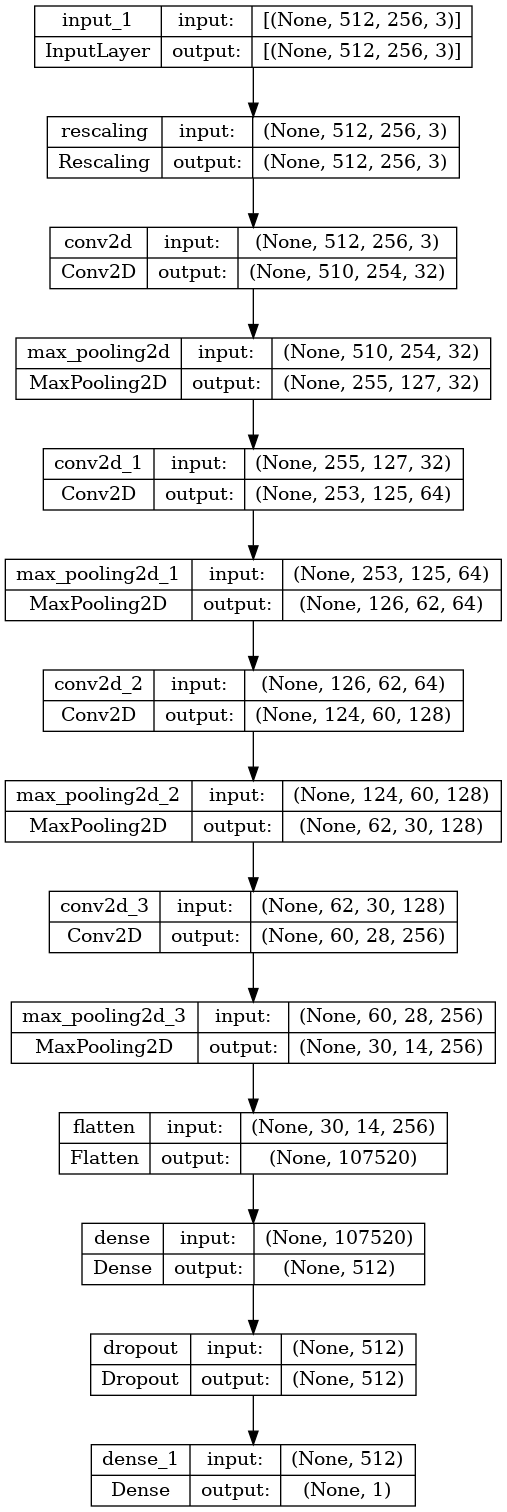

In [33]:
# Define input shape
input_shape = (512,256,3)
input_layer = Input(shape=input_shape)
_input = Rescaling(scale=1./255)(input_layer)
# Define convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(_input)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(maxpool2)
maxpool3 = MaxPooling2D((2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu')(maxpool3)
maxpool4 = MaxPooling2D((2, 2))(conv4)

# Flatten and add fully connected layers
flatten = Flatten()(maxpool4)
dense1 = Dense(512, activation='relu')(flatten)
dropout1 = Dropout(0.1)(dense1)
output_layer = Dense(1, activation='sigmoid')(dropout1)

# Define model and compile
bcd_model = Model(inputs=input_layer, outputs=output_layer)

plot_model(bcd_model,show_shapes=True)

# Use of pretrained models

In [34]:
bcd_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [37]:
history = bcd_model.fit(
    train_dataset,
    epochs=20,
    callbacks=[early_stopping],
    batch_size=config.batch_size,
    validation_data=validation_dataset
)

Epoch 1/20
427/427 [==============================] - 116s 240ms/step - loss: 0.5449 - accuracy: 0.7264 - val_loss: 0.4214 - val_accuracy: 0.8138
Epoch 2/20
427/427 [==============================] - 65s 151ms/step - loss: 0.3871 - accuracy: 0.8355 - val_loss: 0.4032 - val_accuracy: 0.8376
Epoch 3/20
427/427 [==============================] - 65s 152ms/step - loss: 0.3370 - accuracy: 0.8579 - val_loss: 0.3470 - val_accuracy: 0.8573
Epoch 4/20
427/427 [==============================] - 66s 152ms/step - loss: 0.2848 - accuracy: 0.8879 - val_loss: 0.3470 - val_accuracy: 0.8644
Epoch 5/20
427/427 [==============================] - 64s 148ms/step - loss: 0.2432 - accuracy: 0.9034 - val_loss: 0.4355 - val_accuracy: 0.8259
Epoch 6/20
427/427 [==============================] - 65s 151ms/step - loss: 0.2031 - accuracy: 0.9171 - val_loss: 0.4209 - val_accuracy: 0.8439
Epoch 7/20
427/427 [==============================] - 65s 151ms/step - loss: 0.1466 - accuracy: 0.9447 - val_loss: 0.4716 - val_a

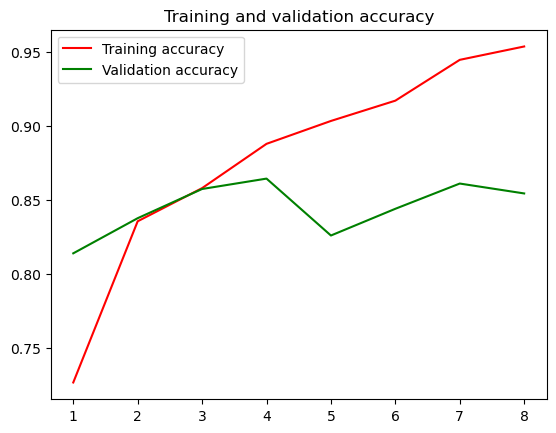

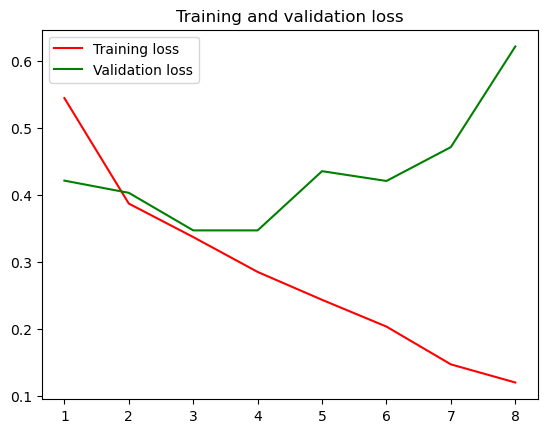

In [38]:
#Displaying curves of loss and accuracy during training

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "g", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Define input shape
input_shape = (512,256,3)
# Load the pre-trained EfficientNetB0 model with imagenet weights
base_model = EfficientNetB3(weights='imagenet', 
                            include_top=False, 
                            input_shape=input_shape)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(units=1,activation='sigmoid')(x)

# Create a new model with the EfficientNetB0 base and the new head
bcd_model = Model(inputs=base_model.input,outputs=x)

# plot_model(bcd_model,show_shapes=True)

43941136/43941136 [==============================] - 0s 0us/step


In [40]:
bcd_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [41]:
history = bcd_model.fit(
    train_dataset,
    epochs=20,
    callbacks=[early_stopping],
    batch_size=config.batch_size,
    validation_data=validation_dataset)

Epoch 1/20


2023-04-07 13:53:46.222779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


427/427 [==============================] - 158s 344ms/step - loss: 0.3002 - accuracy: 0.8863 - val_loss: 0.2876 - val_accuracy: 0.8825
Epoch 2/20
427/427 [==============================] - 143s 334ms/step - loss: 0.2525 - accuracy: 0.9094 - val_loss: 0.2571 - val_accuracy: 0.9059
Epoch 3/20
427/427 [==============================] - 143s 334ms/step - loss: 0.2389 - accuracy: 0.9144 - val_loss: 0.2482 - val_accuracy: 0.9035
Epoch 4/20
427/427 [==============================] - 144s 335ms/step - loss: 0.2301 - accuracy: 0.9179 - val_loss: 0.2506 - val_accuracy: 0.8999
Epoch 5/20
427/427 [==============================] - 143s 334ms/step - loss: 0.2230 - accuracy: 0.9166 - val_loss: 0.2445 - val_accuracy: 0.9035
Epoch 6/20
427/427 [==============================] - 143s 333ms/step - loss: 0.2202 - accuracy: 0.9194 - val_loss: 0.2639 - val_accuracy: 0.8935
Epoch 7/20
427/427 [==============================] - 144s 335ms/step - loss: 0.2104 - accuracy: 0.9214 - val_loss: 0.2672 - val_accura

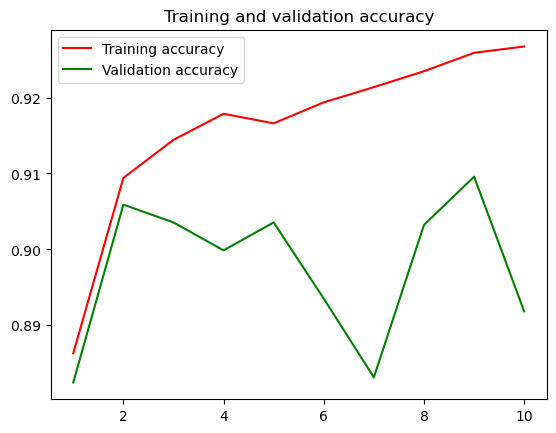

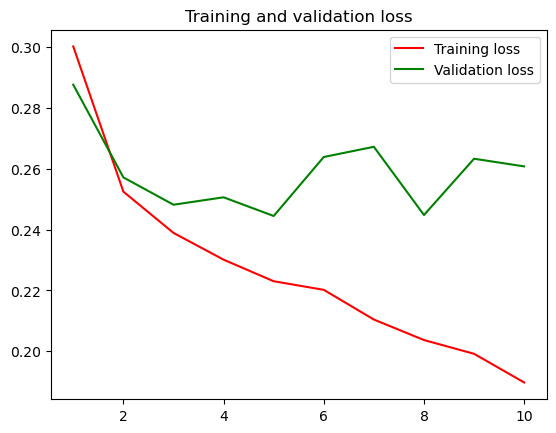

In [42]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "g", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()